In [ ]:
!pip freeze > requirements.txt


In [ ]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib onnx onnxruntime
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h_4b8939.pth


PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121
CUDA is available: True
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.1 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-vh3n44bh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-vh3n44bh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=c017af2ba1ac100465ce4f7c6a5d7ff094f0cf4732d89c143b3030ae3095f9c8
  Stored in directory: /tmp

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnx
import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic



In [ ]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [ ]:
import  warnings
# option: convert pytorch to onnx with 12 version
checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=checkpoint)

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

onnx_model_path = "sam_model_v12.onnx"

with open(onnx_model_path, "wb") as f:
    torch.onnx.export(
        onnx_model,
        tuple(dummy_inputs.values()),
        f,
        export_params=True,
        verbose=False,
        opset_version=12,  #  opset
        do_constant_folding=True,
        input_names=list(dummy_inputs.keys()),
        output_names=output_names,
        dynamic_axes=dynamic_axes,
    )


/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/transformer.py:232: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  attn = attn / math.sqrt(c_per_head)
/usr/local/lib/python3.10/dist-packages/segment_anything/utils/onnx.py:97: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  score_reweight = torch.tensor(
/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:5858: UserWarning: Exporting aten::index operator of advanced indexing in opset 12 is achieved by combination of multiple ONNX opera

In [ ]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.0 MB/s eta 0:00:00


In [ ]:
!pip install onnx_tf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf

# load onnx model
onnx_model_path = "sam_model_v12.onnx"
onnx_model = onnx.load(onnx_model_path)

# use ONNX-TF to convert ONNX into TensorFlow ，set the  auto_cast to True
tf_rep = prepare(onnx_model, auto_cast=True)
tf_rep.export_graph("sam_model_tf")

# convert the  TensorFlow to TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("sam_model_tf")
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # use TensorFlow Lite to convert
    tf.lite.OpsSet.SELECT_TF_OPS  # start up TensorFlow Select implementation
]
tflite_model = converter.convert()

# save tflite file
with open("sam_model.tflite", "wb") as f:
    f.write(tflite_model)
print("TensorFlow convert to  TFLite succeed ")


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow convert to  TFLite succeed 


In [ ]:
from google.colab import files

files.download('sam_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import cv2


Test the onnx_12v can be worked **correctly**

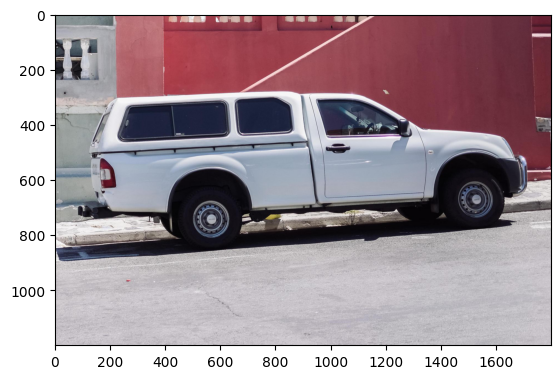

In [ ]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('on')
plt.show()

In [ ]:
ort_session = onnxruntime.InferenceSession("sam_model_v12.onnx")

In [ ]:
sam.to(device="cuda")
predictor = SamPredictor(sam)

In [ ]:
predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()
image_embedding.shape

(1, 256, 64, 64)

point input

In [ ]:
input_point = np.array([[830,1000]])
input_label = np.array([1])

In [ ]:
import onnx

# Load the ONNX model
onnx_model = onnx.load("sam_model_v12.onnx")

# Print the input and output details of the ONNX model
for input in onnx_model.graph.input:
    print(f"Input {input.name}: shape={[dim.dim_value for dim in input.type.tensor_type.shape.dim]}, dtype={input.type.tensor_type.elem_type}")

for output in onnx_model.graph.output:
    print(f"Output {output.name}: shape={[dim.dim_value for dim in output.type.tensor_type.shape.dim]}, dtype={output.type.tensor_type.elem_type}")


Input image_embeddings: shape=[1, 256, 64, 64], dtype=1
Input point_coords: shape=[1, 0, 2], dtype=1
Input point_labels: shape=[1, 0], dtype=1
Input mask_input: shape=[1, 1, 256, 256], dtype=1
Input has_mask_input: shape=[1], dtype=1
Input orig_im_size: shape=[2], dtype=1
Output masks: shape=[0, 0, 0, 0], dtype=1
Output iou_predictions: shape=[0, 1], dtype=1
Output low_res_masks: shape=[0, 1, 0, 0], dtype=1


In [ ]:
from onnx_tf.backend import prepare
import tensorflow as tf

# Convert ONNX model to TensorFlow model
tf_rep = prepare(onnx_model, auto_cast=True)
tf_rep.export_graph("sam_model_tf")

# Load the TensorFlow model
saved_model_dir = "sam_model_tf"
model = tf.saved_model.load(saved_model_dir)

# Print the input and output details of the TensorFlow model
concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

for input in concrete_func.inputs:
    print(f"Input {input.name}: shape={input.shape}, dtype={input.dtype}")

for output in concrete_func.outputs:
    print(f"Output {output.name}: shape={output.shape}, dtype={output.dtype}")


Input has_mask_input:0: shape=(1,), dtype=<dtype: 'float32'>
Input image_embeddings:0: shape=(1, 256, 64, 64), dtype=<dtype: 'float32'>
Input mask_input:0: shape=(1, 1, 256, 256), dtype=<dtype: 'float32'>
Input orig_im_size:0: shape=(2,), dtype=<dtype: 'float32'>
Input point_coords:0: shape=(1, None, 2), dtype=<dtype: 'float32'>
Input point_labels:0: shape=(1, None), dtype=<dtype: 'float32'>
Input unknown:0: shape=(2, 128), dtype=<dtype: 'float32'>
Input unknown_0:0: shape=(1, 256), dtype=<dtype: 'float32'>
Input unknown_1:0: shape=(1, 256), dtype=<dtype: 'float32'>
Input unknown_2:0: shape=(1, 256), dtype=<dtype: 'float32'>
Input unknown_3:0: shape=(1, 256), dtype=<dtype: 'float32'>
Input unknown_4:0: shape=(1, 256), dtype=<dtype: 'float32'>
Input unknown_5:0: shape=(4, 1, 2, 2), dtype=<dtype: 'float32'>
Input unknown_6:0: shape=(4,), dtype=<dtype: 'float32'>
Input unknown_7:0: shape=(4, 1, 1), dtype=<dtype: 'float32'>
Input unknown_8:0: shape=(4, 1, 1), dtype=<dtype: 'float32'>
Input

In [ ]:
import tensorflow as tf
import numpy as np

# load TFLite
interpreter = tf.lite.Interpreter(model_path="sam_model.tflite")
interpreter.allocate_tensors()

# load input and output tensor info
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("TFLite Model Inputs:")
for detail in input_details:
    print(f"Input {detail['name']}: shape={detail['shape']}, dtype={detail['dtype']}")

print("\nTFLite Model Outputs:")
for detail in output_details:
    print(f"Output {detail['name']}: shape={detail['shape']}, dtype={detail['dtype']}")


TFLite Model Inputs:
Input serving_default_point_labels:0: shape=[1 1], dtype=<class 'numpy.float32'>
Input serving_default_image_embeddings:0: shape=[  1 256  64  64], dtype=<class 'numpy.float32'>
Input serving_default_mask_input:0: shape=[  1   1 256 256], dtype=<class 'numpy.float32'>
Input serving_default_point_coords:0: shape=[1 1 2], dtype=<class 'numpy.float32'>
Input serving_default_orig_im_size:0: shape=[2], dtype=<class 'numpy.float32'>
Input serving_default_has_mask_input:0: shape=[1], dtype=<class 'numpy.float32'>

TFLite Model Outputs:
Output StatefulPartitionedCall:0: shape=[1 1], dtype=<class 'numpy.float32'>
Output StatefulPartitionedCall:2: shape=[1 1 1 1], dtype=<class 'numpy.float32'>
Output StatefulPartitionedCall:1: shape=[1 1 1 1], dtype=<class 'numpy.float32'>


In [ ]:
# Convert the TensorFlow model to TFLite model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # use TensorFlow Lite to convert
    tf.lite.OpsSet.SELECT_TF_OPS  # start up TensorFlow Select implementation
]
tflite_model = converter.convert()

# Save the TFLite model
with open("sam_model.tflite", "wb") as f:
    f.write(tflite_model)

# Load the TFLite model and print input and output details
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for detail in input_details:
    print(f"Input {detail['name']}: shape={detail['shape']}, dtype={detail['dtype']}")

for detail in output_details:
    print(f"Output {detail['name']}: shape={detail['shape']}, dtype={detail['dtype']}")


Input serving_default_point_labels:0: shape=[1 1], dtype=<class 'numpy.float32'>
Input serving_default_image_embeddings:0: shape=[  1 256  64  64], dtype=<class 'numpy.float32'>
Input serving_default_mask_input:0: shape=[  1   1 256 256], dtype=<class 'numpy.float32'>
Input serving_default_point_coords:0: shape=[1 1 2], dtype=<class 'numpy.float32'>
Input serving_default_orig_im_size:0: shape=[2], dtype=<class 'numpy.float32'>
Input serving_default_has_mask_input:0: shape=[1], dtype=<class 'numpy.float32'>
Output StatefulPartitionedCall:0: shape=[1 1], dtype=<class 'numpy.float32'>
Output StatefulPartitionedCall:2: shape=[1 1 1 1], dtype=<class 'numpy.float32'>
Output StatefulPartitionedCall:1: shape=[1 1 1 1], dtype=<class 'numpy.float32'>


In [ ]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

In [ ]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

In [ ]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

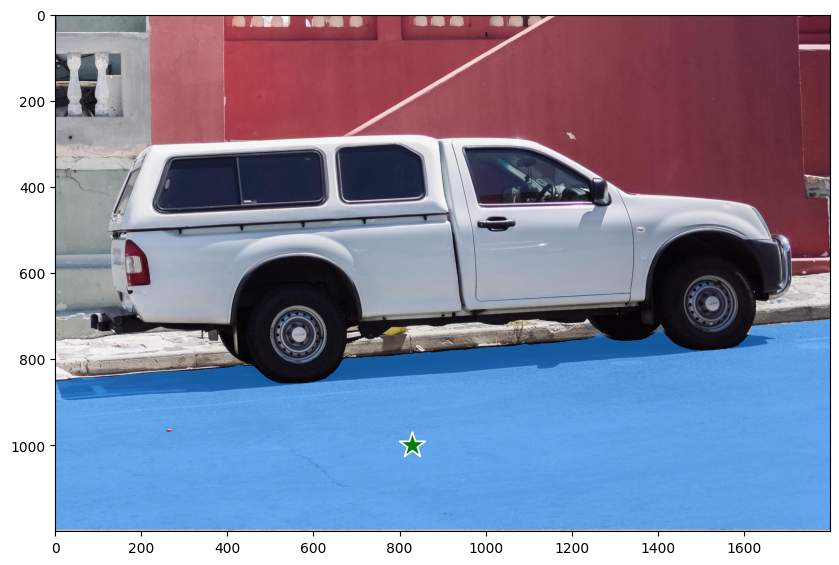

In [ ]:
masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold
masks.shape
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

mask input example

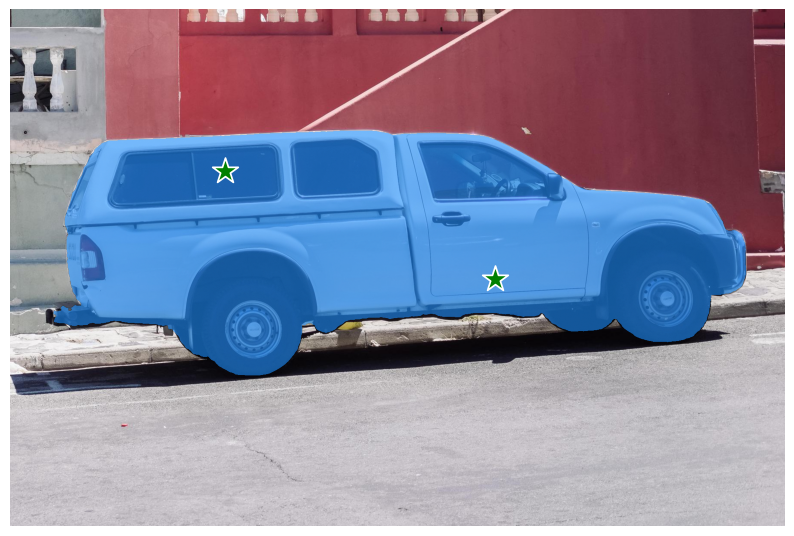

In [ ]:

input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

# Use the mask output from the previous run. It is already in the correct form for
# input to the ONNX model.
onnx_mask_input = low_res_logits
# Transform the points as in the previous example.

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
# The has_mask_input indicator is now 1.

onnx_has_mask_input = np.ones(1, dtype=np.float32)
# Package inputs, then predict and threshold the mask.

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

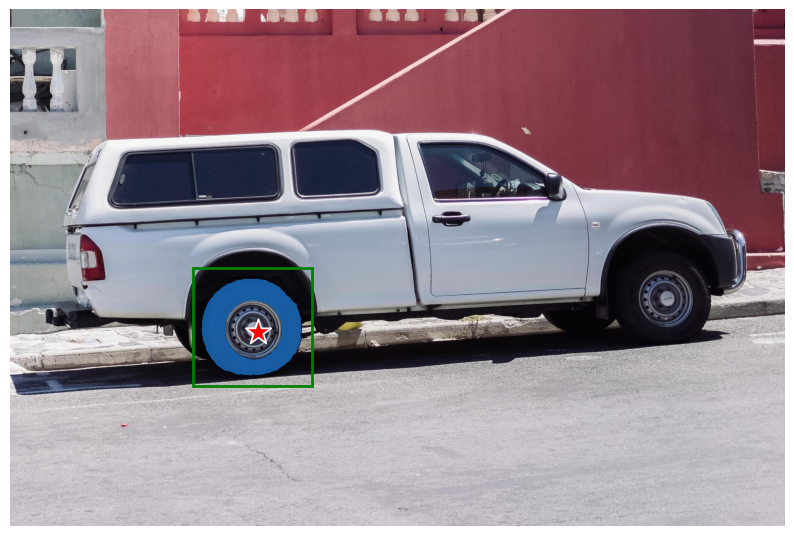

In [ ]:
# Example box and point input
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])
# Add a batch index, concatenate a box and point inputs, add the appropriate labels for the box corners, and transform. There is no padding point since the input includes a box input.

onnx_box_coords = input_box.reshape(2, 2)
onnx_box_labels = np.array([2,3])

onnx_coord = np.concatenate([input_point, onnx_box_coords], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, onnx_box_labels], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
# Package inputs, then predict and threshold the mask.

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

# **use python to implement tflite**

In [ ]:
import tensorflow as tf

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='sam_model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
import numpy as np
import cv2

# Load and preprocess image (assuming this step is similar to your existing preprocessing)
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Using the SAM predictor to get image embedding
sam.to(device='cpu')
predictor = SamPredictor(sam)
predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()

# Assuming other preprocessing steps for point_coords, point_labels, etc.
input_point = np.array([[500, 375]])
input_label = np.array([1])

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)
onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)


In [ ]:
# print tensor infos
for detail in input_details:
    print(f"Input {detail['name']}: {detail['shape']}, {detail['dtype']}")


Input serving_default_point_labels:0: [1 1], <class 'numpy.float32'>
Input serving_default_image_embeddings:0: [  1 256  64  64], <class 'numpy.float32'>
Input serving_default_mask_input:0: [  1   1 256 256], <class 'numpy.float32'>
Input serving_default_point_coords:0: [1 1 2], <class 'numpy.float32'>
Input serving_default_orig_im_size:0: [2], <class 'numpy.float32'>
Input serving_default_has_mask_input:0: [1], <class 'numpy.float32'>
